# Setups/ Imports

# Establishing Baseline Models- WEEKLY DATA

#### Background
The overall goal of this entire project is to create 3000 different weekly forecast for each individual PLU/product. However, in this notebook I will go on a short tangent to check some very important concepts. The purpose of this notebook is to use the previously tranformed 10 broad categories to test if these items are able to be predicted based on their historical data. We would hope to see no random walks, and all 10 categories showing improvements in the prediction errors with more complicated models(another indicator that the data is not a random walk)

#### Plan of Attack

>1. First I will check each each broad category (10 categories) for signal, and make sure these time series are not random walks or white noise data points. White noise is random data points, and random walks are intervals of time that cannot be correlated to their pasts, and therefore make them unpredictable using only historic data. We will use three tests for rancom walks to accomplish this.
>2. Next, I will establish two basic forecasts (Naive Forecast, Moving Average) to use as a baseline 
>3. Finally, I will compare the baseline averages with some slightly more complicated models (Simple Exponential Smoothing, Holts Linear Trend, Holts Winter Model)

#### Metrics

*How shall we comapre the accuracy of different models?*

Suprisingly, there is a lot of different theories revolving around the best metric. One of the most widely used metrics in forecasting for business operations is MAPE (mean absolute percentage error). This is by far the easiest to explain because it simply represents the percentage of error in our predictions out of 100%. However, the forumala for MAPE does not play well with 0's.


>> $\mbox{M} = \frac{100\%}{n}\sum_{t=1}^n  \left|\frac{A_t-F_t}{A_t}\right|$


If the predicted value was 5, but the actual value is 0: 5 divided by zero in undefined. Thus, MAPE really only works when you are not dealing with zero quantities, and given the sparsity of this dataset, there are a lot of zeroes. 

#### Thus, we will default to three metrics:

1. MAE(Mean Absolute Error)
>MAE very simply, takes the average of all the absolute values of your prediction errors. The smaller the number the better, with a 0 MAE meaning there was an average of 0 errors in your prediction!
>MAE will help us measure the difference between a baseline model and the arima model. 
>I chose MAE over MSE because I want to get a general sense of the errors as they are. I'm not so concerned with penalizing higher error with the MSE metric.
2. RMSE (Root Mean Sqaured Error)
>RMSE is very similar to MAE except it doesnt take the absolute value of the error terms, and instead squares them and then takes the square root of those squares. That effectively transforms the data from postive and negative values all the positive AND has the added bonus of really "punishing" the large errors because when you square the number it will accentuate the larger errors. 
> Like MAE, the lower the number the better, but RMSE will typically be larger that MAE because of the squared terms. 
> This will be good to compare and contrast against LARGE errors. Whereas MAE gives us a more level picture of the errors. 
3. Alpha = .05
>For all of the hypothesis testing, I will resort to the industry standard and set the significance level= .05


#### About-Models

>Naive Forecast
>* A Naive forecast is simply taking the previous periods value. This works suprisingly well for random walk time series, and is the most basic/primitive model you can use.

>Moving Average
>* This will serve as a great baseline measure for the ARIMA model
>* a moving average simply makes you name a time period (say 7 days), take the average of the values in that time period, and use that predict tomorrow's value. It is up to you to choose a relevant time period.

>Simple Exponential Smoothing
>* Gives higher weights to recent data, and lower weights to older data and then takes the average of the values with the weights taken into account.

>Holts Linear Trend
>* Holts Linear Trend will do the same as the exponential smoothing, but also take into account the trend of the data

>Holts Winter Model
>* Holts Winter Method does triple exponential smoothing to try to uncover seasonality and trend.
You must calculate the correct seasonality



# Installs:

In [0]:
#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area

#access the OS system to work with current directories:
import os 

Tue Oct 15 17:23:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%pip install hurst

In [0]:
#imports
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from sklearn import metrics
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.despine()
sns.set(rc={'figure.figsize':(15,9)})
%matplotlib inline

# Importing & Cleaning

In [0]:
#Import the cleaned up data frame from the "clean up report"
#Turn the CSV files into data frames
#dfqty = pd.read_csv('drive/My Drive/Capstone_2/data/correct_cat_pivot.csv', index_col= 'invdate', low_memory=False)#categories to test models
dfqty = pd.read_csv('drive/My Drive/Capstone_2/data/single_items.csv', index_col= 'invdate', low_memory=False)#individual items to test models

#Adding total columns
dfqty ["total"]= dfqty.sum(axis = 1, skipna = True)

#resetting index to datetime
dfqty.index = pd.to_datetime(dfqty.index)


#### We DONT want negative values because they represent returns and NOT demand. Returns is a separate analysis to look at and should not be mixed with this forecast


In [0]:
#counting negative values
print (np.sum((dfqty < 0).values.ravel())) 

#replacing negative values/ returns with 0
dfqty[dfqty < 0] = np.nan
dfqty = dfqty.fillna(0)

47


In [0]:
#filling in the missing days for both dfs
idx = pd.date_range('2018-08-24', '2019-08-23')
dfqty = dfqty.reindex(idx, fill_value=0)


In [0]:
print (f'dfqty shape= {dfqty.shape} \n')

dfqty shape= (365, 13) 



# Steps:

1. Decomposition of the timeseries (trends, seasonality, and noise)
2. Checking for white noise
3. Checking for random walks
4. Splitting into test/train splits
5. Naive forecast
6. Simple Moving Average
7. More complicated models


***
# 1. Decomposition (Seasonality, Trend, Noise)

#### What is it?

Basically it's an handy way to look at the abstract of timeseries data. It uses stastistical methods to break down the time series into three components:

* seasonality:
>* does the data display a clear periodic pattern?

* trend:
>* does the data follow a consistent upwards or downward slope?

* noise:
>* are there any outlier points or missing values that are not consistent with the rest of the data?


***The BLUE line represents the total amount of grocery items***


<Figure size 432x288 with 0 Axes>

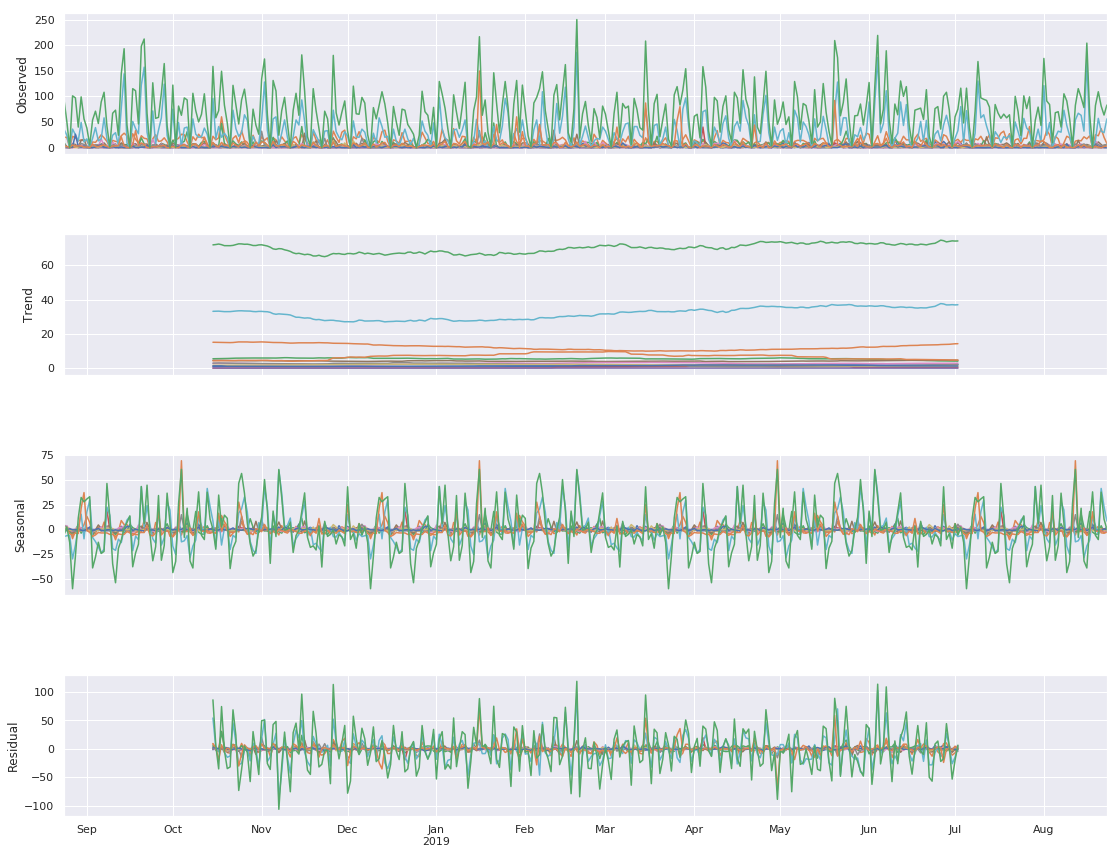

In [0]:
#fig, ax1 = plt.subplots(figsize=(20, 10))

from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(dfqty, freq=104) #104 for bi-weekly predictions

fig = plt.figure()  
fig = decomp.plot()  
fig.set_size_inches(18, 14)

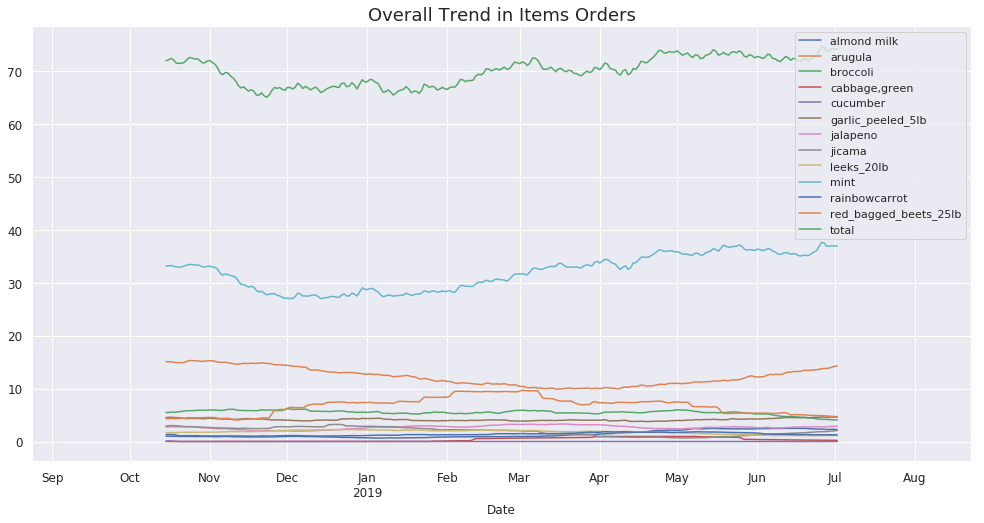

In [0]:
#A CLOSER LOOK AT TREND

# Perform time series decompositon
decomposition = sm.tsa.seasonal_decompose(dfqty, freq=104)

# Extract the trend component
trend = decomposition.trend

# Plot the values of the trend
ax = trend.plot(figsize=(15, 8), fontsize=12)

# Specify axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Overall Trend in Items Orders', fontsize=18)
plt.show()

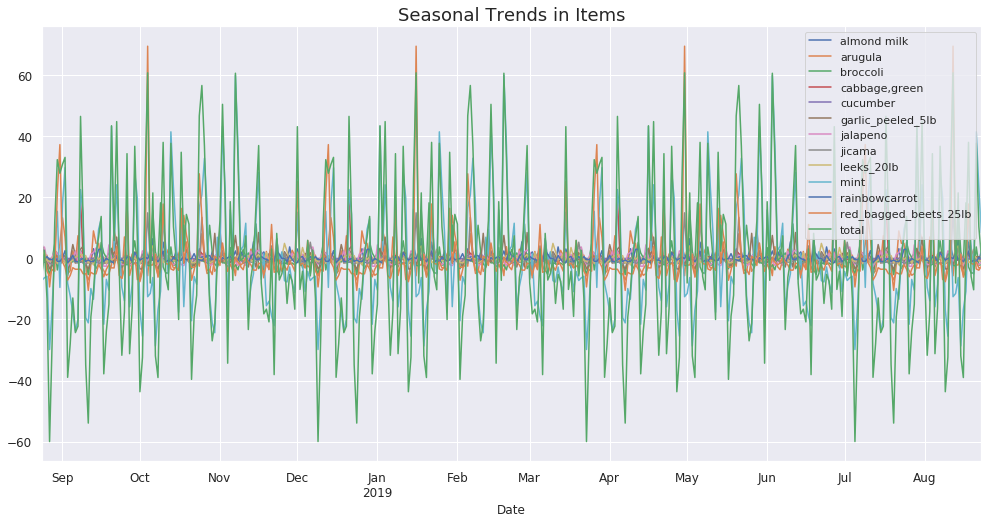

In [0]:
# A CLOSER LOOK AT SEASONALITY
seasonality = decomposition.seasonal

ax = seasonality.plot(figsize=(15, 8), fontsize=12)

# Specify axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Seasonal Trends in Items', fontsize=18)
plt.show()

#### Insights


* Trend:
> Generally stationary and not growing or declining, but the fruit and the dairy/juice category looks like a slight upward trend.
* Seasonality:
>* Seems to go in quarterly increments
* Noise
> Looks fairly random which is what we want.



# 2. Checking for White Noise 

#### What is it?

* White noise means all the entries are identically distributed with a mean of zero independent of each other
>* Basically, this means that the entries are random entries, and for timeseries forcasting we need to be able to detect patterns in the data

* Two Times to Check for White Noise:

>1. You first check for white noise in the beginning to make sure you can create a forecasting model
>2. You check after you make a prediction using your model, and make sure the residuals of your prediction ARE producing white noise. 
>>* If the errors of your model are white noise this is good because it means your model used all possible signal or trends in the data to produce it's prediction. If your model diagnostics do not produce white noise, then it means there's more you can do to improve your model.

> *In the **beginning** you do not want your data to be white noise. At the **end** you want your model to produce random residuals (white noise).*


#### Why it matters

1. This makes it impossible to make a forecasting model if there's white noise in the beginning
2. This means you can work to improve your model if you find white noise in the end

#### Characteristics of a White Noise

*   mean = close to zero
*   standard deviation = close to 1
*   constant variance

#### Difference between White Noise and a Random Walk

A random walk differs from white noise because it is talking about the steps (or chunks of time) being random & independent, but not the points themselves. Also, the variance increases linearly with each step (not constant). 

To put it simply, think the of S & P: white noise is like the daily changes of the points of the S & P, while a random walk is the S&P daily level itself.

In [0]:
dfqty.describe()

,almond milk,arugula,broccoli,"cabbage,green",cucumber,garlic_peeled_5lb,jalapeno,jicama,leeks_20lb,mint,rainbowcarrot,red_bagged_beets_25lb,total
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,1.372603,13.112795,5.146904,0.276712,0.032877,4.301370,2.855616,2.209589,1.617123,33.014384,1.345205,5.919945,70.919397
std,2.482536,9.087923,6.300932,2.223162,0.424541,4.126552,2.890246,3.994576,1.951898,31.705461,2.098210,12.663829,47.942969
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,11.000000,0.000000,1.000000,37.140000
50%,0.000000,13.000000,4.000000,0.000000,0.000000,4.000000,2.000000,1.000000,1.000000,26.000000,1.000000,3.000000,71.000000
75%,2.000000,18.000000,7.000000,0.000000,0.000000,6.000000,5.000000,3.000000,2.000000,47.000000,2.000000,6.000000,98.000000
max,15.000000,60.000000,48.000000,40.000000,7.000000,34.000000,17.000000,42.000000,14.000000,186.000000,26.000000,149.500000,250.000000


#### Insights:
* Based on our ACL/ PACL graphs, and the mean, variance, and STD stastics below, we can safely say our data is **NOT** white noise, and we can use timeseries forecasting to predict the inventory.


# 3. Checking for Random Walks
#### What is it?
* Random Walks typically happen in financial data a lot. It basically means the data is taking successive steps that are random (think a literal "random walk"). The steps are successive, but not predictable. Within each period the variable takes a random step away from its previous value, and the steps are independently and identically distributed in size (“i.i.d.”). 
* This concept was popularized in 1973 with the publishing of "A Random Walk Down Wallstreet" [book link](https://https://en.wikipedia.org/wiki/A_Random_Walk_Down_Wall_Street)
* The best prediction for a random walk is to look at the previous "step" or timeframe and use that to predict the future value. This is called a "Naive" or baseline forecast.
* If we dont have a random walk process, we will not be able to predict future changes.

#### Why it matters?
* It is important that we will not be diving into creating complicated models for random walk processes because they won't be able to beat the naive model.

#### How to check?
1. We will be using the Augmented Dickey-Fuller hypothesis test. With this test, the null hypothesis is that the time series IS a non-stationary series. Thus, we want all the p-values to be below .05 which means we have a 5% or less chance to see a value this extreme or greater, and we can reject the null hypothesis that they are non-stationary

2. Check the Hurst Exponent

3. Check correlogram plots of original data.

4. Check correlogram plots for the converted stationary data.

5. Does the Naive model outperform more complicated models? We will measure this in sections 6, 7, & 8.


## 3.1 Checking for Stationarity

In [0]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

for col in dfqty.columns:
   results = adfuller(dfqty[col])
   print (f"{col} p-value= {str(results[1])}")

almond milk p-value= 0.09736543610690462
arugula p-value= 0.15295893444952113
broccoli p-value= 0.0022275290587185684
cabbage,green p-value= 2.7228460524169476e-30
cucumber p-value= 9.697436396145933e-23
garlic_peeled_5lb p-value= 8.907758072851209e-05
jalapeno p-value= 0.00446781416276448
jicama p-value= 4.027315191143017e-22
leeks_20lb p-value= 0.0003356186728085743
mint p-value= 0.0001867144733953758
rainbowcarrot p-value= 2.8194882817769725e-09
red_bagged_beets_25lb p-value= 2.606565084358368e-30
total p-value= 0.00030480596531017365


#### Tomatoe, Fruit, and Dairy_Juice are above the .05 threshold and could use some differencing techniques. To make it simple we will difference the entire dataframe, and then be able to reverse that afterwards.

Text(0.5, 1.0, 'Log Graph')

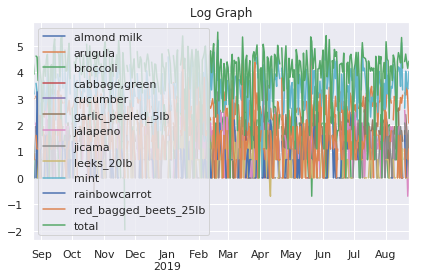

In [0]:
#Logging the data frame to transform the data into stationary
dflog = np.log(dfqty)
dflog.dropna(inplace= True)
dflog.plot()
plt.title("Log Graph")

Text(0.5, 1.0, 'Diff Graph')

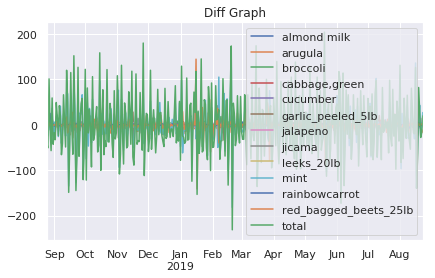

In [0]:
#Differencing the data frame to transform the data into stationary
diff = dfqty - dfqty.shift(1)
diff.dropna(inplace= True)
diff.plot()
plt.title("Diff Graph")

In [0]:
print ("Checking for stationarity with difference data")
for col in diff.columns:
   results = adfuller(diff[col])
   print (f"{col} p-value= {str(results[1])}")

Checking for stationarity with difference data
almond milk p-value= 5.347051396274206e-18
arugula p-value= 4.4078711723421105e-18
broccoli p-value= 6.8559497974679006e-18
cabbage,green p-value= 5.238049932695482e-14
cucumber p-value= 0.0
garlic_peeled_5lb p-value= 4.62802869519629e-11
jalapeno p-value= 2.6243897512904864e-16
jicama p-value= 2.684947577594186e-15
leeks_20lb p-value= 1.96412757594702e-14
mint p-value= 5.90501623129311e-17
rainbowcarrot p-value= 1.1558814938133447e-14
red_bagged_beets_25lb p-value= 5.789611434001344e-16
total p-value= 1.370649065243206e-20


#### Excellent, it worked! These p-values represent VERY extremely small statistical chance that the data is NOT stationary. The chances that they are not stationary are so small, we can reject the null hypothesis and say that they are in fact stationary.

#### Insights:

* Tomatoe, Fruit, and dairy_juice are above the .05 threshold and so we used some differencing techniques. To make it simple we differenced the entire dataframe, and then be able to reverse that afterwards.

* This produced incredibly strong statistical stationary results after the difference, and will be good to measure the auto correlation with the stationary data.

## 3.2 Hurst Exponent
* The Hurst Exponenent is another way to measure if a time series is a random walk. 
* If the Hurst exponent is > .5 it is trending
* < .5 and its anti-persistent time series
* Close to .5 and its a random walk

In [0]:
from hurst import compute_Hc, random_walk

#hurst for the regular data
print ("Regular Data:\n")
for col in dfqty.columns:
  H, c, data = compute_Hc(diff[col], kind='change', simplified=True)
  print (f'{col} Hurst Exp: {H}')

#hurst for the differenced data
print ("\nDifferenced Data:\n")
for col in diff.columns:
  H, c, data = compute_Hc(diff[col], kind='change', simplified=True)
  print (f'{col} Hurst Exp: {H}')

Regular Data:

almond milk Hurst Exp: 0.2318394872224003
arugula Hurst Exp: 0.23096161336294532
broccoli Hurst Exp: 0.245090734211051
cabbage,green Hurst Exp: 0.4969053896611715
cucumber Hurst Exp: 0.5120489376860392
garlic_peeled_5lb Hurst Exp: 0.2915126248704559
jalapeno Hurst Exp: 0.20110533692928553
jicama Hurst Exp: 0.37244947854765353
leeks_20lb Hurst Exp: 0.2500681849332295
mint Hurst Exp: 0.17900359049144568
rainbowcarrot Hurst Exp: 0.3997441719817631
red_bagged_beets_25lb Hurst Exp: 0.40476923444031193
total Hurst Exp: 0.1321552474629854

Differenced Data:

almond milk Hurst Exp: 0.2318394872224003
arugula Hurst Exp: 0.23096161336294532
broccoli Hurst Exp: 0.245090734211051
cabbage,green Hurst Exp: 0.4969053896611715
cucumber Hurst Exp: 0.5120489376860392
garlic_peeled_5lb Hurst Exp: 0.2915126248704559
jalapeno Hurst Exp: 0.20110533692928553
jicama Hurst Exp: 0.37244947854765353
leeks_20lb Hurst Exp: 0.2500681849332295
mint Hurst Exp: 0.17900359049144568
rainbowcarrot Hurst Ex

#### Insights
* At .518, the meat category reeks of a random walk process, and probably needs to be dropped, but we will first look at the correlograms.
* All the other categories look good.

## 3.3 Correlgram Plots
Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. 

In [0]:
dflog.index= pd.to_datetime(dflog.index)


Correlogram of the Different Categories with Regular Data = Green


Correlogram of the Different Categories with Differenced Data = Red



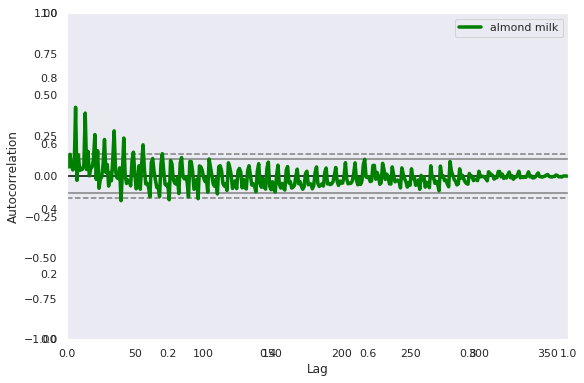

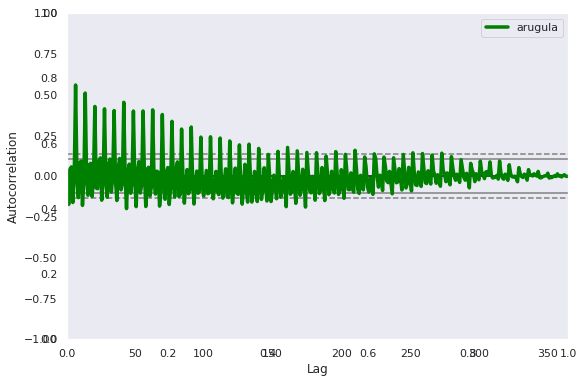

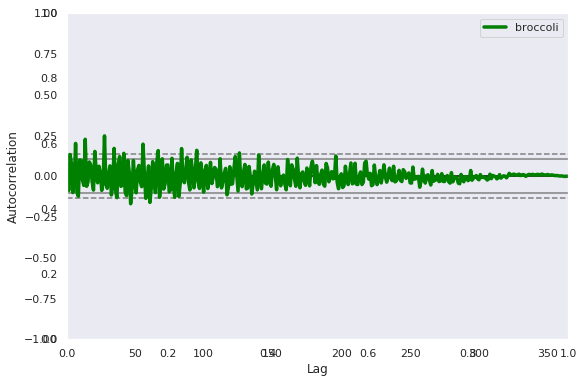

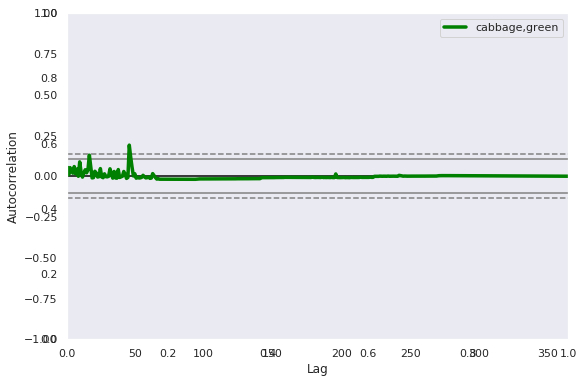

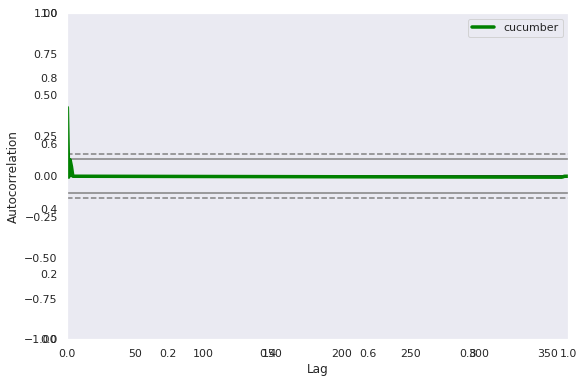

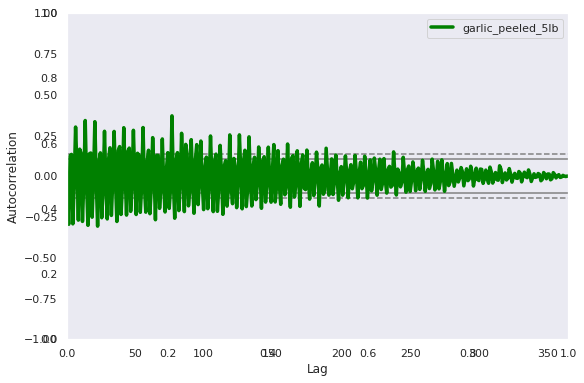

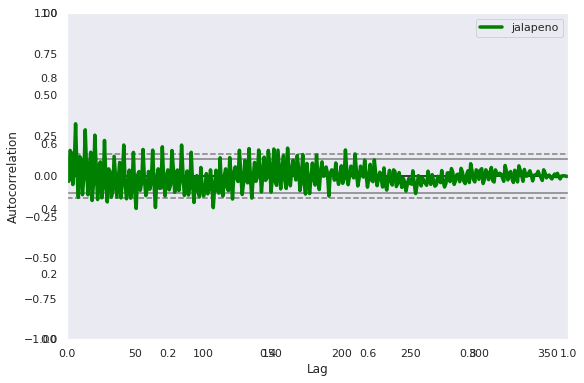

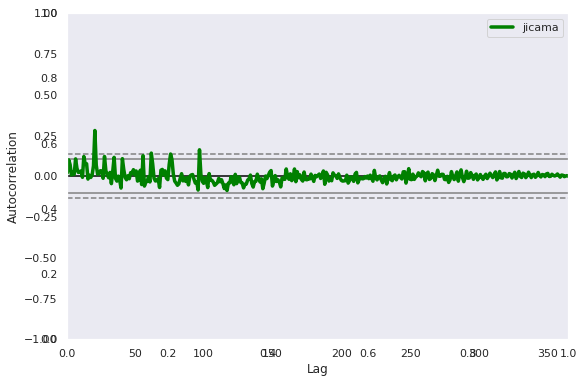

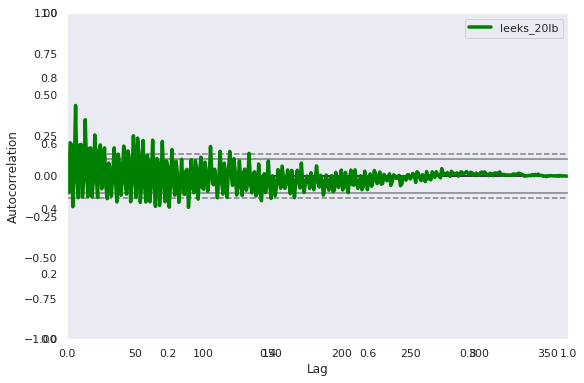

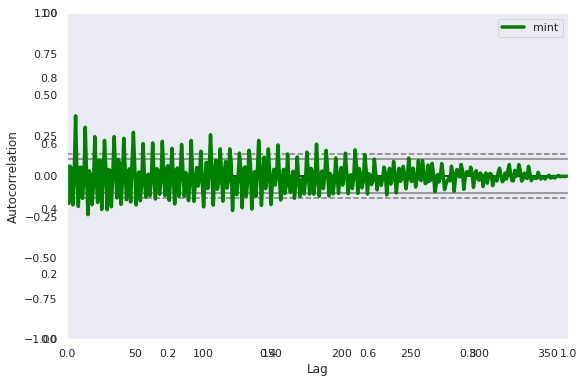

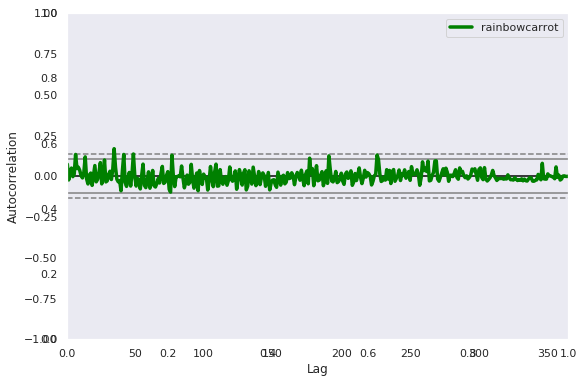

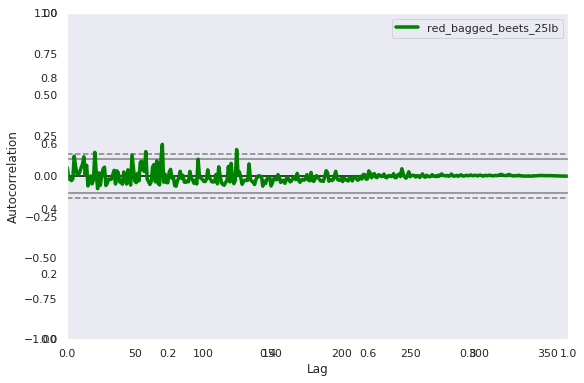

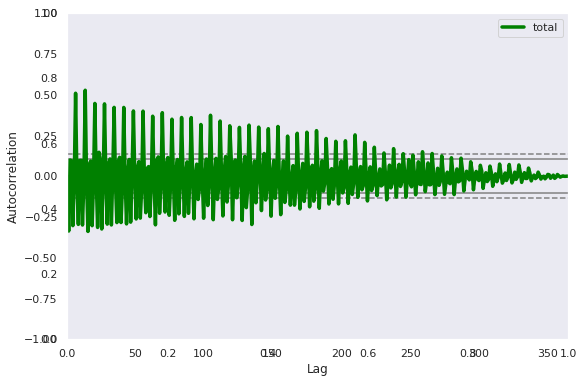

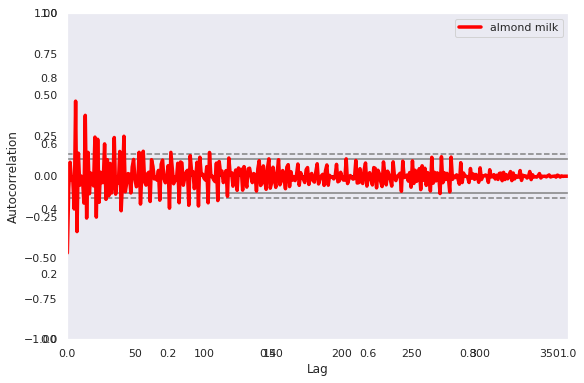

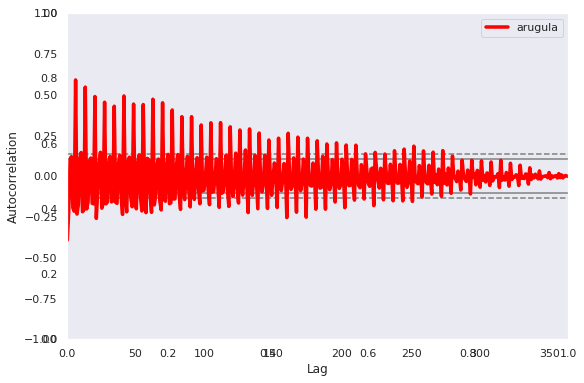

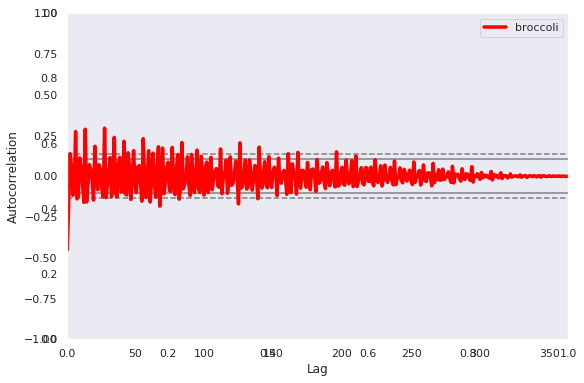

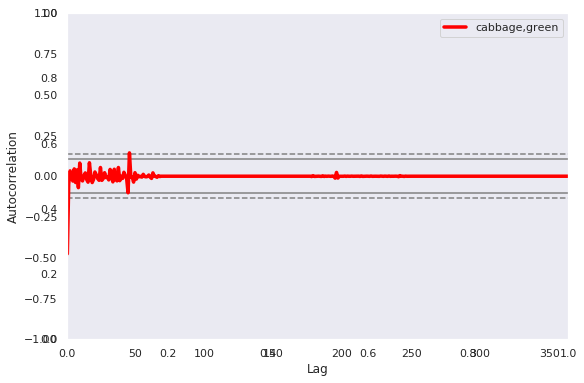

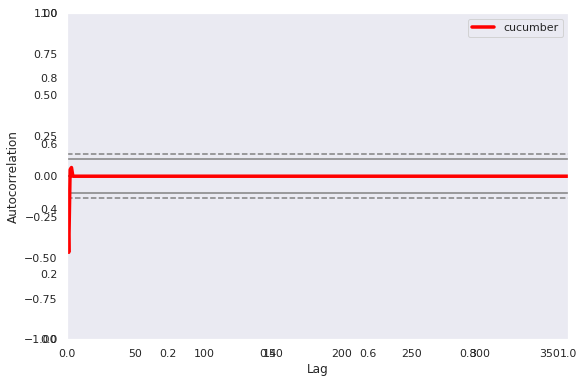

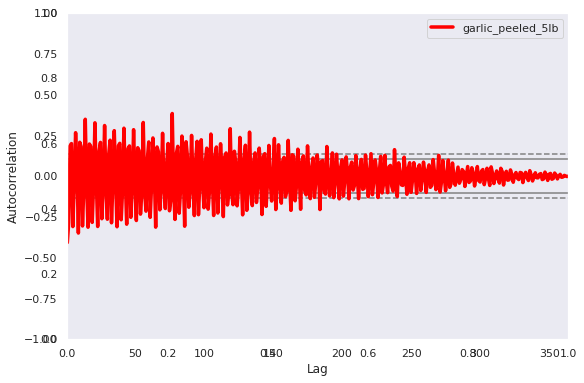

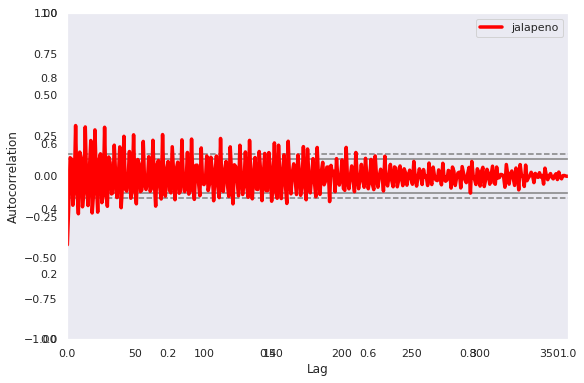

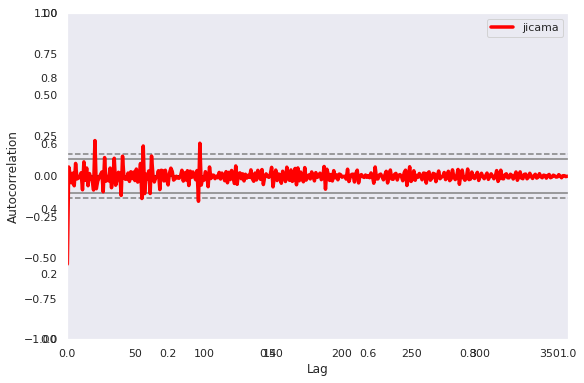

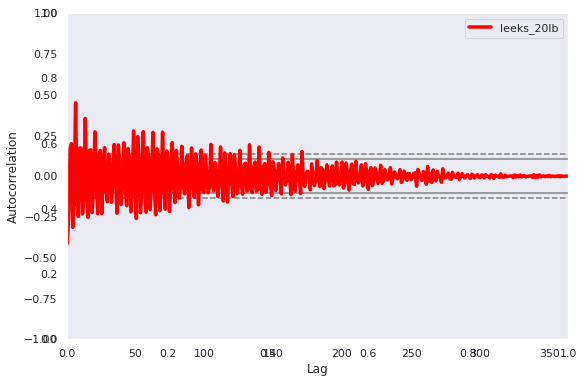

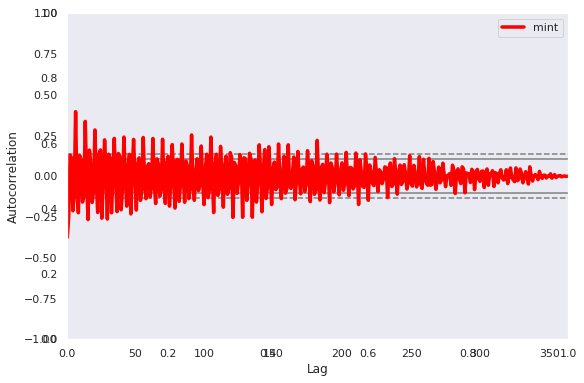

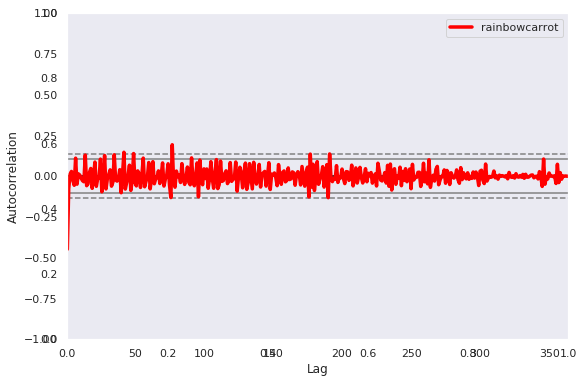

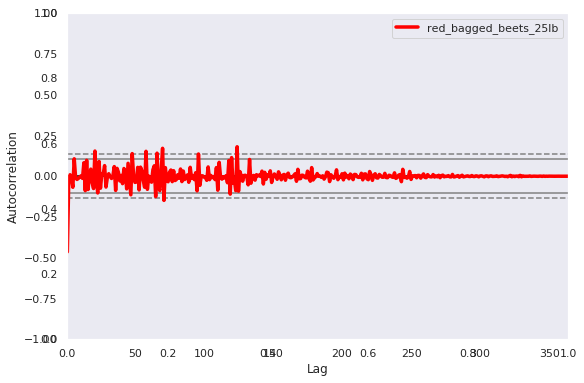

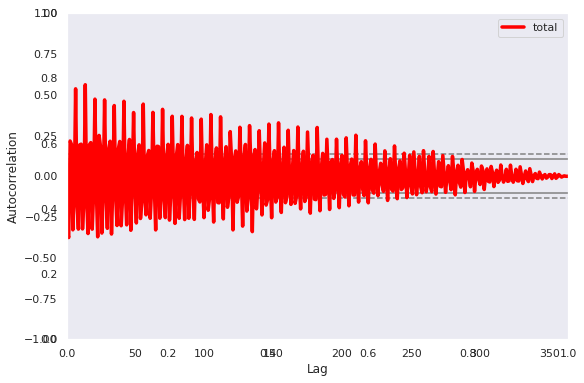

In [0]:
from pandas.plotting import autocorrelation_plot

#Regular data
print("\nCorrelogram of the Different Categories with Regular Data = Green\n")
for col in dfqty.columns:
  plt.subplots(1, figsize=(8,6))
  autocorrelation_plot(dfqty[col], label= col, linewidth=3.5, color='green')
  plt.legend()

#Differenced data
print("\nCorrelogram of the Different Categories with Differenced Data = Red\n")
for col in diff.columns:
  plt.subplots(1, figsize=(8,6))
  autocorrelation_plot(diff[col], label= col, linewidth=3.5, color='red')
  plt.legend()



ACL Plot for Differenced Data



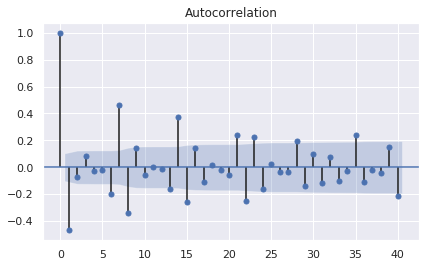

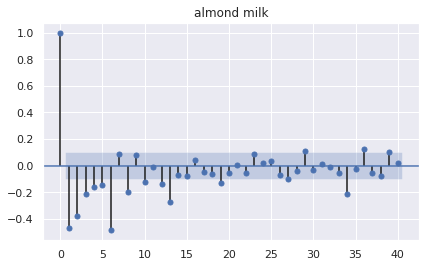

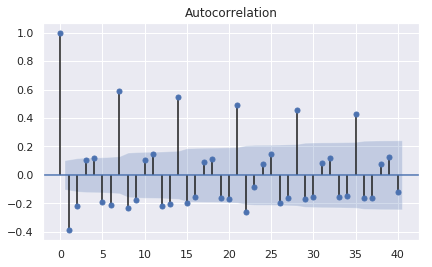

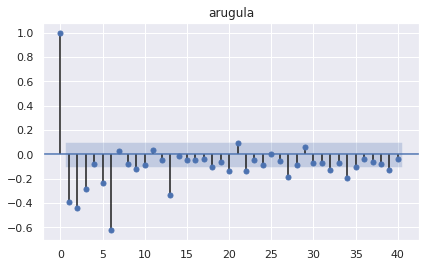

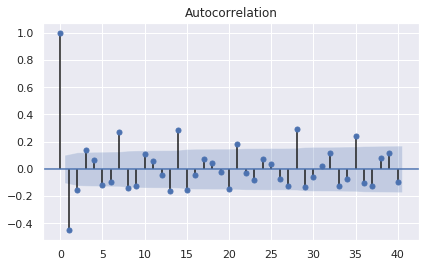

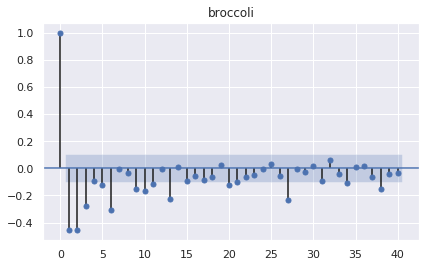

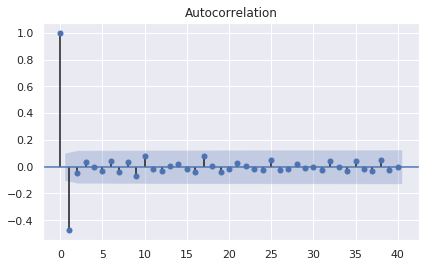

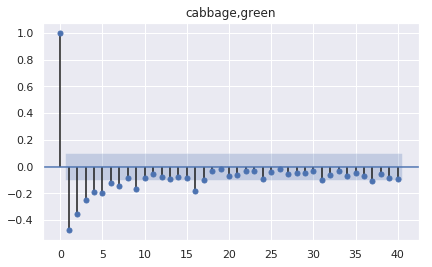

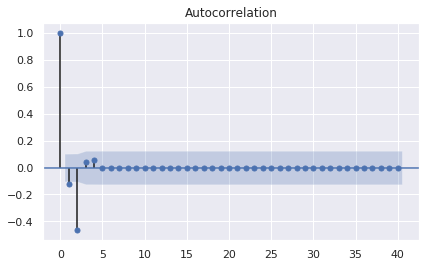

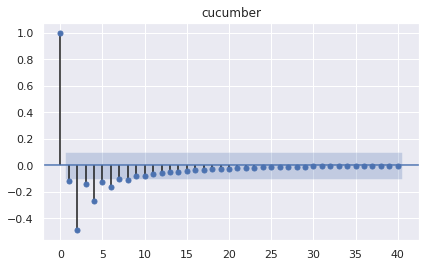

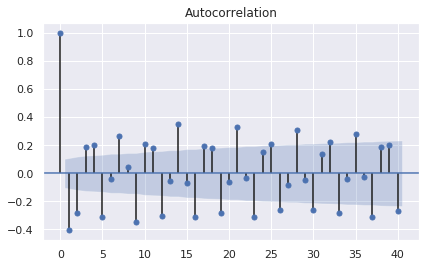

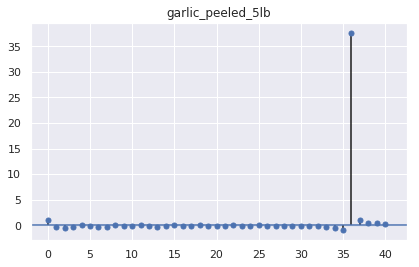

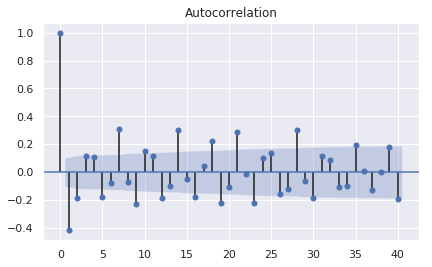

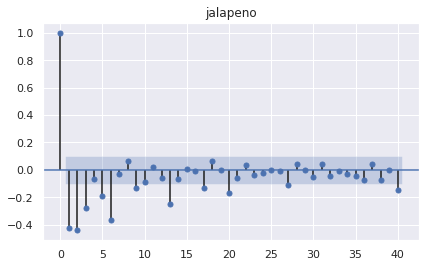

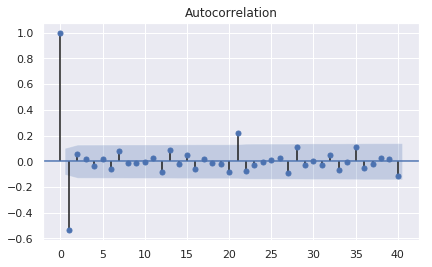

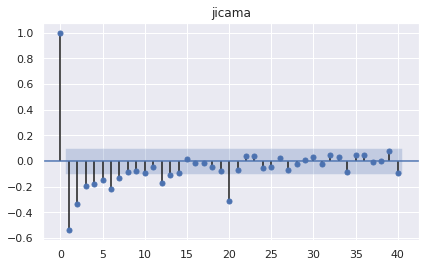

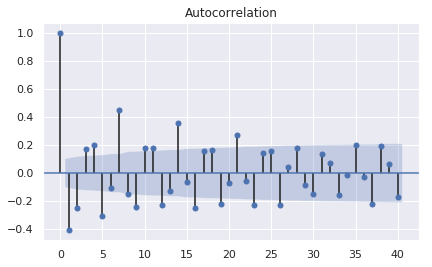

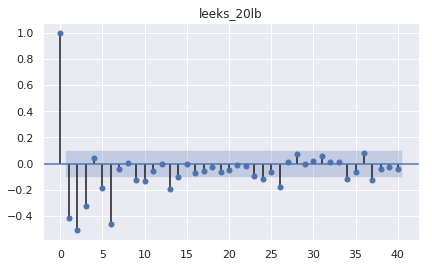

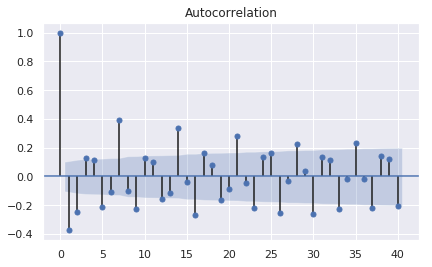

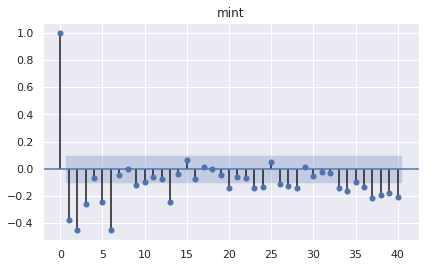

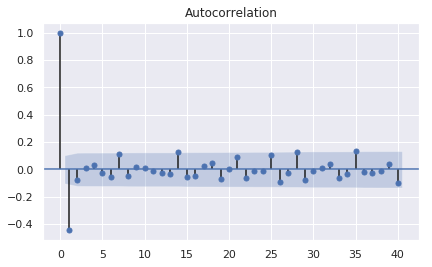

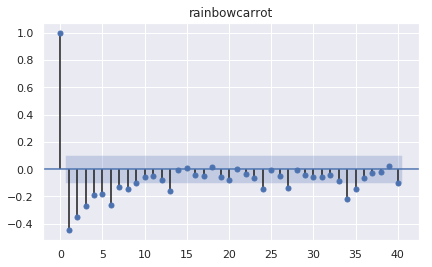

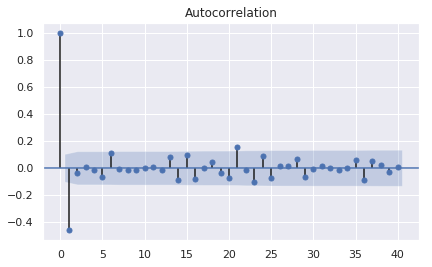

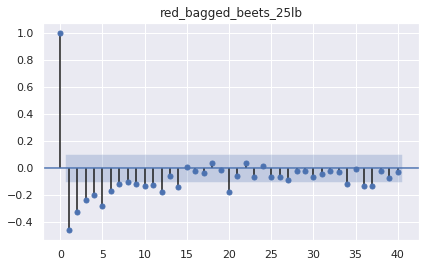

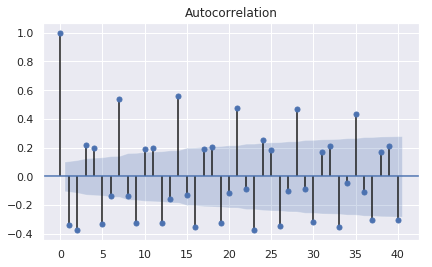

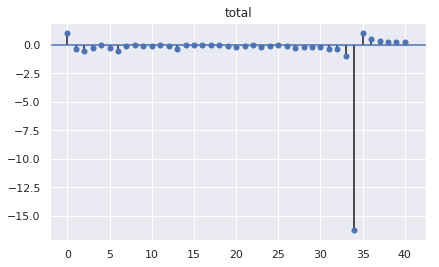

In [0]:
#Plotting the non-stationary data

# print ("ACL Plot for Regular Data\n")
# for col in dfqty.columns:
#   sm.graphics.tsa.plot_acf(diff[col], lags=40)
#   sm.graphics.tsa.plot_pacf(diff[col], lags=40)
#   plt.title(col)

print ("ACL Plot for Differenced Data\n")
for col in diff.columns:
  sm.graphics.tsa.plot_acf(diff[col], lags=40)
  sm.graphics.tsa.plot_pacf(diff[col], lags=40)
  plt.title(col)

# fig = plt.figure(figsize=(16,9))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(train.total, lags=40, ax=ax1) # 
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(train.total, lags=40, ax=ax2)# , lags=40

#### Insights


* This is excellent! All the categories (except meat) show statistically signficant correlation to the past values even when we take away any slight trend with the differencing. 
* When we look at the auto-correlation of the differenced data, its basically taking away any slight indication of trend. Thus, we are asking it, when no trend is there any relation from todays value to the past? 
* All categories show a signal from the past. This is MUCH better than our first attempt with data using 2017 entries.
* Also, the ACL plots are showing weekly seasonality as well as two spikes midweek that we will want to pinpoint a bit better.
* Finally, it is time bare farewell to the meat category.



In [0]:
#Dropping the meat category

dfty = dfqty.drop(columns=['meat'])

KeyError: ignored

# 4. Splitting into Train/ Test Sets

Before all these delicious predictions can take place, we must first split the data into train and test sets!

>* Since a timeseries forecast is dependent on having the trends of the past, it is not possible to take a random sample of the dataset because it would ruin the historic pattern. Thus, in timeseries forecasting, the standard is to set aside continuous time periods of data, usually the most recent period.
>* I will segment the data from July 1st, 2019 
>* Also, I will be using the regular data (not the differenced df) because my models can all handle non-stationary data


In [0]:
#Splitting data into train/test splits
train= dfqty[:'2019-07-01'] 
test= dfqty['2019-07-01':]
print (f"Percent of Training Data = {test.shape[0]/ train.shape[0]*100:.3f} %")
## The training data represents around 9.5% of the entire time series

Percent of Training Data = 17.308 %


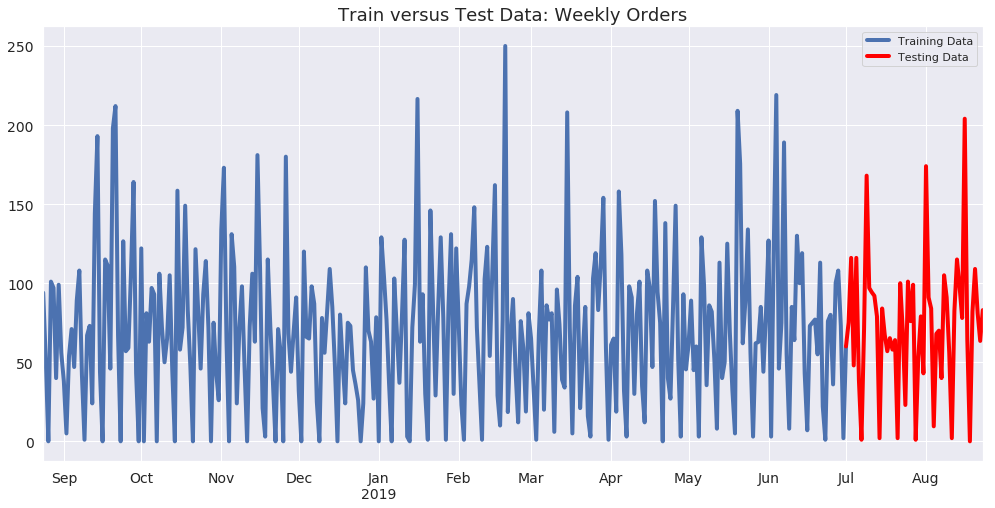

In [0]:
#Graphing the test versus training 
train.total.plot(figsize=(15,8), label= 'Training Data', fontsize=14, linewidth= 4)
test.total.plot(figsize=(15,8), label='Testing Data' , fontsize=14, linewidth= 4, color= 'red')
plt.legend()
plt.title('Train versus Test Data: Weekly Orders', fontsize= 18)
plt.show()

In [0]:
#imports
from sklearn.metrics import mean_squared_error

In [0]:
#create an empty data frame to store all the results
results_m = pd.DataFrame() #results with MAE
results_r = pd.DataFrame() #results with RMSE

# 5. Naive Forecast- Establishing a Baseline Measure


*   With this model, we will establish a basline measure to measure all of our models against
*   The Naive forecast *literally* only takes the past value and inserts it into the present timeframe. No calculations, just a simple shifting of data from one timeframe to another.
* This is a very important metric for this data in particular because if we cannot beat the outcome of this Naive forecast, then we truly have random walks on our hands.





In [0]:
#literally JUST taking the value from the past timeframe and inserting into the present forecast
predictions= pd.DataFrame()
for col in test.columns:
    predictions[col]= test[col].shift(1)


In [0]:
  #Getting rid of the first NaN row to compute MAE
  df = test.iloc[1:]
  predict= predictions.iloc[1:]

In [0]:
#Computing MAE for each column
from sklearn.metrics import mean_absolute_error
# mean_absolute_error(dfqty[col], predict[col]

print ("---RESULTS OF NAIVE FORECAST PREDICTION PER CATEGORY---\n")
mae_n={}
rmse_n= []
for col in df.columns:
  mae_nv = mean_absolute_error(df[col], predict[col])
  mae_n[col]= round(mean_absolute_error(df[col], predict[col]))
  print (f"{col} MAE = {mae_nv}")
  rmse_n.append(sqrt(mean_squared_error(df[col], predict[col])))

#adding the results to the results data frame
results_m["naive"]= mae_n.values()
results_r["naive"]= rmse_n

---RESULTS OF NAIVE FORECAST PREDICTION PER CATEGORY---

almond milk MAE = 1.7924528301886793
arugula MAE = 11.037735849056604
broccoli MAE = 3.3679245283018866
cabbage,green MAE = 0.0
cucumber MAE = 0.0
garlic_peeled_5lb MAE = 4.9245283018867925
jalapeno MAE = 2.981132075471698
jicama MAE = 3.0754716981132075
leeks_20lb MAE = 1.0
mint MAE = 34.68867924528302
rainbowcarrot MAE = 0.7547169811320755
red_bagged_beets_25lb MAE = 2.8679245283018866
total MAE = 48.179245283018865


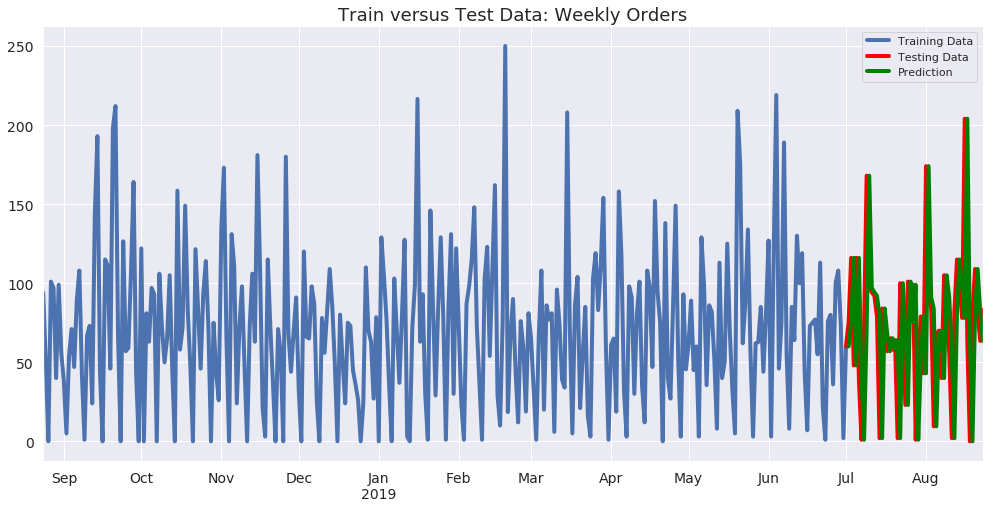

In [0]:
train.total.plot(figsize=(15,8), label= 'Training Data', fontsize=14, linewidth= 4)
test.total.plot(figsize=(15,8), label='Testing Data' , fontsize=14, linewidth= 4, color= 'red')
predictions.total.plot(figsize=(15,8), label='Prediction' , fontsize=14, linewidth= 4, color= 'green')
plt.legend()
plt.title('Train versus Test Data: Weekly Orders', fontsize= 18)
plt.show()

*Look how good the naive model does! Just kidding... it fits the actual data so well because your literally just taking the value from yesterday for today. Thus, it looks like its a great fit when in reality it definitely is not so.*

# 6. Simple Moving Average- Another Basic Model

* Averages equally the amount of past periods you specify
* Will use some gridsearch methods to figure out the optimal time period to go backwards
* Then I will calculate each time period per category


In [0]:
#GOING TESTING HOW MANY PERIODS ARE BEST TO GO BACKWARD FOR SIMPLE MOVING AVERAGE. 


#MAE

y_hat_avg = test.copy()

print ("\nTESTING FOR THE BEST NUMBER OF ROLLING PERIODS BASED ON MAE: \n")

#create  a for loop to figure out the best number of periods to go backward
for i in range(30):
  
  y_hat_avg['moving_avg_forecast'] = train['total'].rolling(i).mean().iloc[-1] # i in rolling means we are consider i periods (i weeks) of previous data to make our prediction
  y_hat_avg['moving_avg_forecast'].fillna(0, inplace= True)
  mean_absolute_error(test.total, y_hat_avg.moving_avg_forecast)
  ma_mae =  mean_absolute_error(test.total, y_hat_avg.moving_avg_forecast)
  print(f"Number of periods: {i} \n MAE = {ma_mae}")
  

y_hat_avg = test.copy()

print ("\nTESTING FOR THE BEST NUMBER OF ROLLING PERIODS BASED ON RMSE: \n")

#create  a for loop to figure out the best number of periods to go backward
for i in range(30):
  
  y_hat_avg['moving_avg_forecast'] = train['total'].rolling(i).mean().iloc[-1] # i in rolling means we are consider i periods (i weeks) of previous data to make our prediction
  y_hat_avg['moving_avg_forecast'].fillna(0, inplace= True)
  rms = sqrt(mean_squared_error(test.total, y_hat_avg.moving_avg_forecast))
  print(f"Number of periods: {i} \n RMSE = {rms}")
  
  


TESTING FOR THE BEST NUMBER OF ROLLING PERIODS BASED ON MAE: 

Number of periods: 0 
 MAE = 73.17592592592592
Number of periods: 1 
 MAE = 32.638888888888886
Number of periods: 2 
 MAE = 49.861111111111114
Number of periods: 3 
 MAE = 40.49074074074074
Number of periods: 4 
 MAE = 32.361111111111114
Number of periods: 5 
 MAE = 30.16444444444444
Number of periods: 6 
 MAE = 31.453703703703702
Number of periods: 7 
 MAE = 30.774074074074072
Number of periods: 8 
 MAE = 30.48518518518518
Number of periods: 9 
 MAE = 32.81090534979424
Number of periods: 10 
 MAE = 34.47296296296296
Number of periods: 11 
 MAE = 32.26178451178451
Number of periods: 12 
 MAE = 32.447530864197525
Number of periods: 13 
 MAE = 31.97792022792023
Number of periods: 14 
 MAE = 31.628306878306873
Number of periods: 15 
 MAE = 31.374691358024688
Number of periods: 16 
 MAE = 32.68472222222222
Number of periods: 17 
 MAE = 33.08943355119825
Number of periods: 18 
 MAE = 31.811728395061724
Number of periods: 19 
 M

#### Insights
* The RMSE puts a lot of different date ranges close to each other, thus the magnitute of errors seemed to level out the time periods. We will default to the MAE because it is related to actual differences.
* Weeks 5, 14, 21 seem to be good a timeframe to go back to calculate the moving average. 

In [0]:
#training models based on the best roll back periods
y_hat_avg2 = test.copy()
mae_sma2={}
rmse_2= []
print ("\n---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 5 periods---\n")
for col in train.columns: 
  y_hat_avg2[col] = train[col].rolling(5).mean().iloc[-1] #rolling = 5 means the number of weeks to go backwards
  mae2 = mean_absolute_error(test[col], y_hat_avg2[col])
  mae_sma2[col]=round(mean_absolute_error(test[col], y_hat_avg2[col]))
  rmse_2.append(sqrt(mean_squared_error(test[col], y_hat_avg2[col])))
  print(f"{col} MAE: {mae2}")
  
y_hat_avg16 = test.copy()
mae_sma16={}
rmse_16= []
print ("\n---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 14 periods---\n")
for col in train.columns: 
  y_hat_avg16[col] = train[col].rolling(14).mean().iloc[-1] #rolling = 14 means the number of weeks to go backwards
  mae16 = mean_absolute_error(test[col], y_hat_avg16[col])
  mae_sma16[col]=round(mean_absolute_error(test[col], y_hat_avg16[col]))
  rmse_16.append(sqrt(mean_squared_error(test[col], y_hat_avg16[col])))
  print(f"{col} MAE: {mae16}")


y_hat_avg17 = test.copy()
mae_sma17={}
rmse_17= []
print ("\n---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 21 periods---\n")
for col in train.columns: 
  y_hat_avg17[col] = train[col].rolling(21).mean().iloc[-1] #rolling = 21 means the number of weeks to go backwards
  mae17 = mean_absolute_error(test[col], y_hat_avg17[col])
  mae_sma17[col]=round(mean_absolute_error(test[col], y_hat_avg17[col]))
  rmse_17.append(sqrt(mean_squared_error(test[col], y_hat_avg17[col])))
  print(f"{col} MAE: {mae17}")

#adding the results to the results data frame
results_m["moving_avg_5"]= mae_sma2.values()
results_m["moving_avg_14"]= mae_sma16.values()
results_m["moving_avg_21"]= mae_sma17.values()

results_r["moving_avg_5"]= rmse_2
results_r["moving_avg_14"]= rmse_16
results_r["moving_avg_21"]= rmse_17



---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 5 periods---

almond milk MAE: 3.1703703703703705
arugula MAE: 7.212962962962963
broccoli MAE: 2.3805555555555564
cabbage,green MAE: 0.0
cucumber MAE: 0.0
garlic_peeled_5lb MAE: 2.937037037037037
jalapeno MAE: 2.505555555555556
jicama MAE: 2.5888888888888895
leeks_20lb MAE: 0.8259259259259258
mint MAE: 22.63425925925926
rainbowcarrot MAE: 1.0555555555555556
red_bagged_beets_25lb MAE: 2.352592592592593
total MAE: 30.16444444444444

---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 14 periods---

almond milk MAE: 2.8015873015873023
arugula MAE: 7.546296296296297
broccoli MAE: 2.4583333333333326
cabbage,green MAE: 0.0
cucumber MAE: 0.0
garlic_peeled_5lb MAE: 2.978835978835979
jalapeno MAE: 2.414021164021164
jicama MAE: 2.8439153439153446
leeks_20lb MAE: 0.849206349206349
mint MAE: 22.66600529100529
rainbowcarrot MAE: 1.5793650793650797
red_bagged_beets_25lb MAE: 2.3756613756613763
total MAE: 31.628306878306873

---RESU

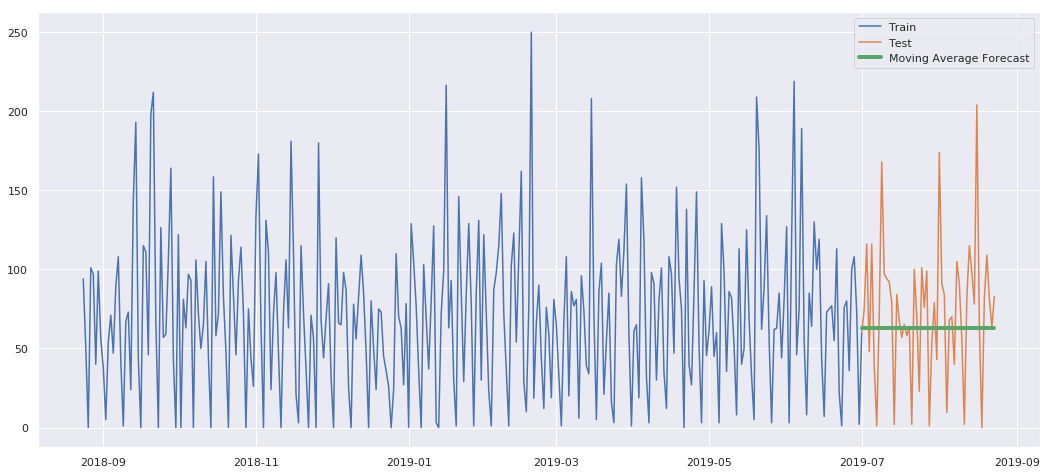

In [0]:
#graph the results
plt.figure(figsize=(16,8))
plt.plot(train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(y_hat_avg16['total'], label='Moving Average Forecast', linewidth= 4)
plt.legend(loc='best')
plt.show()

#### Insights
* I was curious which time period did better... 
* Each category had a different result so it is very much dependent on the type of product of how many time periods to go backward. This will be the case with all the models. With so many different timeseries distributions it's only natural that they need to be customized per SKU
* The Simple moving average model was able to outperform the Naive forecast in all categories except root vegetable and herb. This is good news that a model that's one step above the Naive forecast was able to outperform it. Hoping this will be the case with the more complicated models!
* *Notice something? The predictions are flat! Moving averages by definition are not going to be able to predict trend because when you take the average of past time periods you will always smooth out whatever trend you see.*
 

# 7. Other Classical Models

7.1 Simple Exponential Smoothing
>* Gives higher weights to recent data, and lower weights to older data and then takes the average of the values with the weights taken into account.

7.2 Holts Linear Model
>* Holts Linear Trend will do the same as the exponential smoothing, but also take into account the trend of the data

7.3 Holts Winter Model
>* Holts Winter Method does triple exponential smoothing to try to uncover seasonality and trend.
>* You must calculate the correct seasonality

## 7.1 Exponential Smoothing

In [0]:
#calculating the best alpha

y_hat_ses = test.copy()

for num in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
  
  fit2 = SimpleExpSmoothing(np.asarray(train['total'])).fit(smoothing_level=num,optimized=False)
  y_hat_ses['SES'] = fit2.forecast(len(test))

  #Calculating result
  maes = mean_absolute_error(test.total, y_hat_ses.SES)
  rmses = sqrt(mean_squared_error(test.total, y_hat_ses.SES)) 
  print(f"Alpha: {num} \n MAE = {maes}\n RMSE= {rmses}")

Alpha: 0.1 
 MAE = 30.943322899805253
 RMSE= 42.22009859565183
Alpha: 0.2 
 MAE = 32.77991947794921
 RMSE= 43.55279683877827
Alpha: 0.3 
 MAE = 34.12007089608699
 RMSE= 44.61819884065189
Alpha: 0.4 
 MAE = 35.63293408740293
 RMSE= 45.80267792151443
Alpha: 0.5 
 MAE = 36.99066428061466
 RMSE= 46.91843530666814
Alpha: 0.6 
 MAE = 37.779434330634984
 RMSE= 47.60295325366689
Alpha: 0.7 
 MAE = 37.74465575697399
 RMSE= 47.57208597673401
Alpha: 0.8 
 MAE = 36.77431420247703
 RMSE= 46.736466199072886
Alpha: 0.9 
 MAE = 34.92738176616356
 RMSE= 45.237330712207


####Insights
* .05 alpha gives the best results for RMSE and MAE combined


---RESULTS OF SIMPLE EXPONENTIAL SMOOTHING PREDICTION PER CATEGORY---



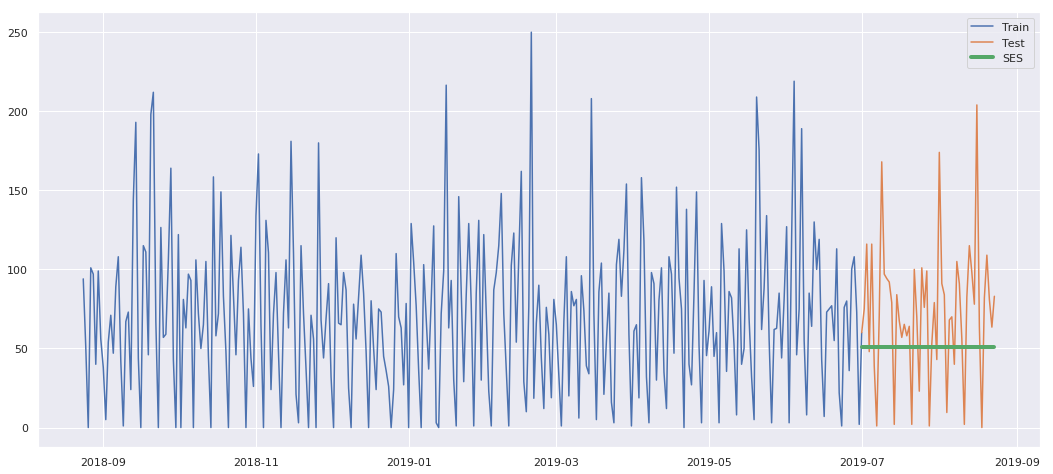

In [0]:
#Imports
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

print ("\n---RESULTS OF SIMPLE EXPONENTIAL SMOOTHING PREDICTION PER CATEGORY---\n")
mae_ses= {}
rmse_ses= []

#Model
for col in train.columns:
  fit2 = SimpleExpSmoothing(np.asarray(train[col])).fit(smoothing_level=0.5,optimized=False) #fit with the optimal alpha .5
  y_hat_ses[col] = fit2.forecast(len(test))
  #Calculating result
  mae_ses[col]=round(mean_absolute_error(test[col], y_hat_ses[col]))
  rmse_ses.append(sqrt(mean_squared_error(test[col], y_hat_ses[col])))
  
#adding the results to the results data frame
results_m["SES"]= mae_ses.values()
results_r["SES"]= rmse_ses


#plot
plt.figure(figsize=(16,8))
plt.plot(train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(y_hat_ses['total'], label='SES', linewidth= 4)
plt.legend(loc='best')
plt.show()

## 7.2 Holt’s Linear Trend method 


In [0]:
#TESTING DIFFERENT PARAMETERS: Holt’s Linear Trend method

for num in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
  for i in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
  
    fit1 = Holt(np.asarray(train['total'])).fit(smoothing_level = num,smoothing_slope = i)
    y_hat_avg['Holt_linear'] = fit1.forecast(len(test))
    mae_ht = mean_absolute_error(test.total, y_hat_avg.Holt_linear)
    rmse_ht = sqrt(mean_squared_error(test.total, y_hat_avg.Holt_linear))
    
    #Calculating result
    print(f"Smoothing level= {num} \n Smoothing slope = {i} \n MAE: {mae_ht} \n RMSE: {rmse_ht}")

Smoothing level= 0.1 
 Smoothing slope = 0.1 
 MAE: 60.67732013911555 
 RMSE: 73.82309375836752
Smoothing level= 0.1 
 Smoothing slope = 0.2 
 MAE: 69.27473267148046 
 RMSE: 82.51868345030684
Smoothing level= 0.1 
 Smoothing slope = 0.3 
 MAE: 49.09536050439233 
 RMSE: 59.39450788898998
Smoothing level= 0.1 
 Smoothing slope = 0.4 
 MAE: 33.587691904887826 
 RMSE: 44.22714239921569
Smoothing level= 0.1 
 Smoothing slope = 0.5 
 MAE: 40.3817010006715 
 RMSE: 50.852363261694066
Smoothing level= 0.1 
 Smoothing slope = 0.6 
 MAE: 80.84696664263555 
 RMSE: 96.62842577394572
Smoothing level= 0.1 
 Smoothing slope = 0.7 
 MAE: 118.22734500833694 
 RMSE: 137.3895383895885
Smoothing level= 0.1 
 Smoothing slope = 0.8 
 MAE: 116.96278202223515 
 RMSE: 134.48012634475012
Smoothing level= 0.1 
 Smoothing slope = 0.9 
 MAE: 78.07637545946265 
 RMSE: 90.02204495982298
Smoothing level= 0.2 
 Smoothing slope = 0.1 
 MAE: 55.86321424453907 
 RMSE: 68.13763699366349
Smoothing level= 0.2 
 Smoothing slo

#### Insights
* Optimal Smoothing level= 0.1 , .2
* Optimal Smoothing slope = 0.8, .4

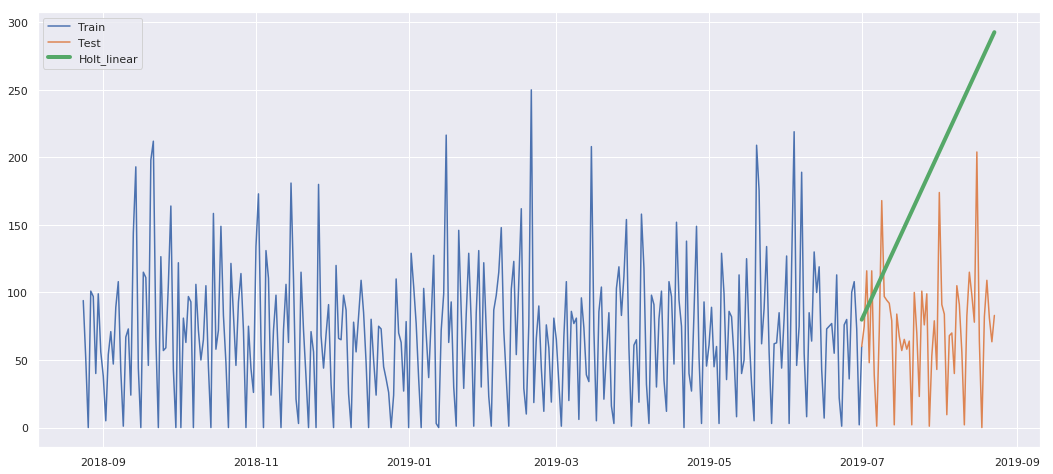

In [0]:
#implementing the mode with the optimal parameters
y_hat_hlt = test.copy()
mae_hlt= {}
rmse_hlt=[]

for col in train.columns:
  fit1 = Holt(np.asarray(train[col])).fit(smoothing_level = 0.1,smoothing_slope = 0.8)
  y_hat_hlt[col] = fit1.forecast(len(test))
  mae_hlt[col]=round(mean_absolute_error(test[col], y_hat_hlt[col]))
  rmse_hlt.append(sqrt(mean_squared_error(test[col], y_hat_hlt[col])))
  
#adding the results to the results data frame
results_m["hlt"]= mae_hlt.values()
results_r["hlt"]= rmse_hlt


plt.figure(figsize=(16,8))
plt.plot(train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(y_hat_hlt['total'], label='Holt_linear', linewidth= 4)
plt.legend(loc='best')
plt.show()

## 7.3 Holt’s Winter Method 

* This method is suposed to capture the seasonality 

In [0]:
#figuring out the optimal number of seasonal periods
y_hat_avg = test.copy()

for num in range(2, 30):
  
  fit1 = ExponentialSmoothing(np.asarray(train['total']) ,seasonal_periods=num ,trend='add', seasonal='add',).fit()
  y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

  mae_h = mean_squared_error(test.total, y_hat_avg.Holt_Winter)

  #Calculating result
  print(f"Number of Seasonal Periods: {num} \n MAE = {mae_h}")

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Number of Seasonal Periods: 2 
 MAE = 4936.199975798557
Number of Seasonal Periods: 3 
 MAE = 5391.842960572982
Number of Seasonal Periods: 4 
 MAE = 2179.0205344184906
Number of Seasonal Periods: 5 
 MAE = 1691.000079833333
Number of Seasonal Periods: 6 
 MAE = 2245.8203580164195
Number of Seasonal Periods: 7 
 MAE = 3519.506698931532


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Number of Seasonal Periods: 8 
 MAE = 2227.462922493409
Number of Seasonal Periods: 9 
 MAE = 2048.116809984169
Number of Seasonal Periods: 10 
 MAE = 2036.5099885243742


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Number of Seasonal Periods: 11 
 MAE = 1985.1468760366313
Number of Seasonal Periods: 12 
 MAE = 2343.632894954742
Number of Seasonal Periods: 13 
 MAE = 2115.4692596191985


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Number of Seasonal Periods: 14 
 MAE = 3495.288475842972
Number of Seasonal Periods: 15 
 MAE = 1921.3034658540585
Number of Seasonal Periods: 16 
 MAE = 2175.4748863591662


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Number of Seasonal Periods: 17 
 MAE = 2165.090272766631
Number of Seasonal Periods: 18 
 MAE = 2272.2353222920315
Number of Seasonal Periods: 19 
 MAE = 2374.4899413875164


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Number of Seasonal Periods: 20 
 MAE = 2107.8272092378957
Number of Seasonal Periods: 21 
 MAE = 3545.768193895942
Number of Seasonal Periods: 22 
 MAE = 1921.069643708305


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Number of Seasonal Periods: 23 
 MAE = 2324.981223468791
Number of Seasonal Periods: 24 
 MAE = 2718.3911937278426
Number of Seasonal Periods: 25 
 MAE = 1935.5708905881122


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Number of Seasonal Periods: 26 
 MAE = 2308.420002021755
Number of Seasonal Periods: 27 
 MAE = 2256.697165016418
Number of Seasonal Periods: 28 
 MAE = 3839.769364457224
Number of Seasonal Periods: 29 
 MAE = 1963.7460879301416


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


#### Insights
* Optimal seasons seems to be 18

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Conver

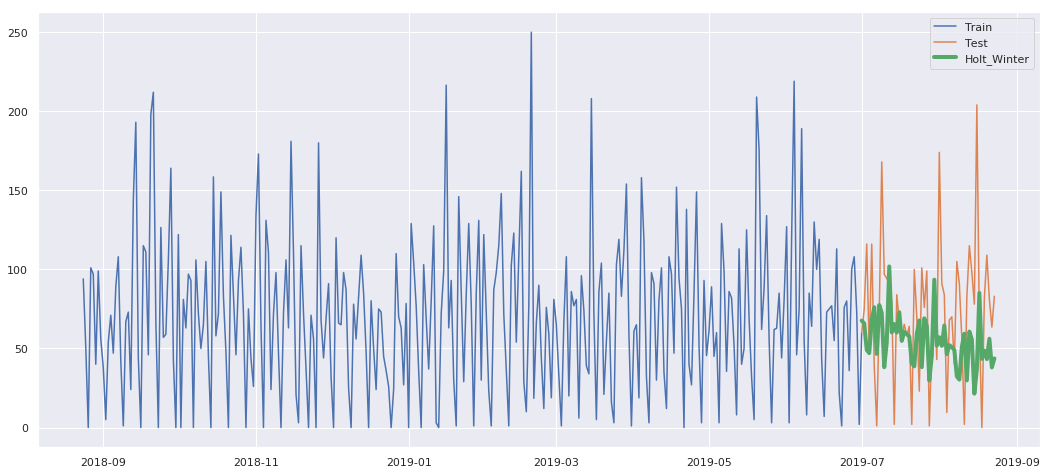

In [0]:
#Testing model with optimal parameters

y_hat_hwm = test.copy()
mae_hwm={}
rmse_hwm = []

for col in train.columns:
  fit1 = ExponentialSmoothing(np.asarray(train['total']) ,seasonal_periods=18 ,trend='add', seasonal='add').fit()
  y_hat_hwm[col] = fit1.forecast(len(test))
  mae_hwm[col]= round(mean_absolute_error(test[col], y_hat_hwm[col]))
  rmse_hwm.append(sqrt(mean_squared_error(test[col], y_hat_hwm[col])))


#adding the results to the results data frame
results_m["hwm"]= mae_hwm.values()
results_r["hwm"]= rmse_hwm
  

plt.figure(figsize=(16,8))
plt.plot( train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(y_hat_hwm['total'], label='Holt_Winter', linewidth= 4)
plt.legend(loc='best')
plt.show()

In [0]:
#cleaning up the results dataframe
results_m.set_index(train.columns, inplace= True)
results_r.set_index(train.columns, inplace= True)

In [0]:
print (results_m)

                       naive  moving_avg_5  moving_avg_14  ...   SES    hlt   hwm
almond milk              2.0           3.0            3.0  ...   2.0   10.0  54.0
arugula                 11.0           7.0            8.0  ...   9.0   26.0  39.0
broccoli                 3.0           2.0            2.0  ...   2.0   12.0  52.0
cabbage,green            0.0           0.0            0.0  ...   0.0    5.0  55.0
cucumber                 0.0           0.0            0.0  ...   0.0    0.0  55.0
garlic_peeled_5lb        5.0           3.0            3.0  ...   3.0   10.0  50.0
jalapeno                 3.0           3.0            2.0  ...   3.0    9.0  51.0
jicama                   3.0           3.0            3.0  ...   2.0    6.0  51.0
leeks_20lb               1.0           1.0            1.0  ...   1.0   12.0  54.0
mint                    35.0          23.0           23.0  ...  24.0  117.0  35.0
rainbowcarrot            1.0           1.0            2.0  ...   1.0    9.0  54.0
red_bagged_beets

In [0]:
#results_m['best_m'] = results_m.idxmin(axis=1)
results_r['best_m'] = results_r.idxmin(axis=1)

In [0]:
results_m

,naive,moving_avg_5,moving_avg_14,moving_avg_21,SES,hlt,hwm
almond milk,2.0,3.0,3.0,3.0,2.0,10.0,54.0
arugula,11.0,7.0,8.0,8.0,9.0,26.0,39.0
broccoli,3.0,2.0,2.0,3.0,2.0,12.0,52.0
"cabbage,green",0.0,0.0,0.0,0.0,0.0,5.0,55.0
cucumber,0.0,0.0,0.0,0.0,0.0,0.0,55.0
garlic_peeled_5lb,5.0,3.0,3.0,3.0,3.0,10.0,50.0
jalapeno,3.0,3.0,2.0,2.0,3.0,9.0,51.0
jicama,3.0,3.0,3.0,3.0,2.0,6.0,51.0
leeks_20lb,1.0,1.0,1.0,1.0,1.0,12.0,54.0
mint,35.0,23.0,23.0,22.0,24.0,117.0,35.0


In [0]:
results_r

,naive,moving_avg_5,moving_avg_14,moving_avg_21,SES,hlt,hwm,best_m
almond milk,2.993704,3.406312,2.973141,3.376739,2.155431e+00,11.063257,56.016946,SES
arugula,14.095028,9.630440,9.880068,9.880068,1.106435e+01,30.768465,42.582235,moving_avg_5
broccoli,4.290457,3.038800,3.008056,3.310046,3.026038e+00,14.855973,54.303905,moving_avg_14
"cabbage,green",0.000000,0.000000,0.000000,0.000000,5.592943e-12,5.660455,57.042731,naive
cucumber,0.000000,0.000000,0.000000,0.000000,1.462181e-92,0.000002,57.042731,naive
garlic_peeled_5lb,6.229873,3.958208,3.931282,3.939779,4.158002e+00,11.381842,52.118041,moving_avg_14
jalapeno,3.827655,3.037695,2.952077,2.936352,3.394081e+00,10.492010,53.508763,moving_avg_21
jicama,3.935806,3.428530,3.710901,3.693999,3.027611e+00,7.528956,53.925915,SES
leeks_20lb,1.324657,1.025959,0.999811,0.954693,9.842159e-01,13.573830,56.066904,moving_avg_21
mint,47.157429,33.122755,34.497529,33.550785,3.704086e+01,131.233816,41.330301,moving_avg_5


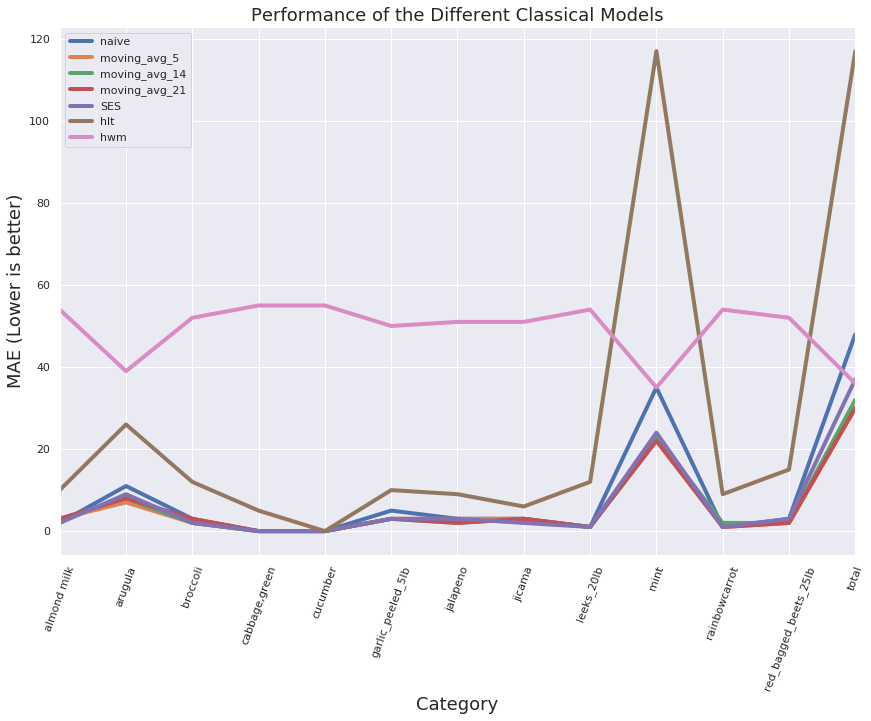

In [0]:
#displaying the results of all the classical models:

def plot_models(df, title= None, ylabel= None):
  df.plot(figsize=(12,8), linewidth= 4)
  plt.tight_layout()
  plt.title(title, fontsize= 18)
  plt.xticks(range(df.shape[0]), df.index, rotation = 70)
  plt.xlabel("Category", fontsize= 18)
  plt.ylabel(ylabel, fontsize= 18)
  
plot_models(results_m, "Performance of the Different Classical Models", "MAE (Lower is better)")

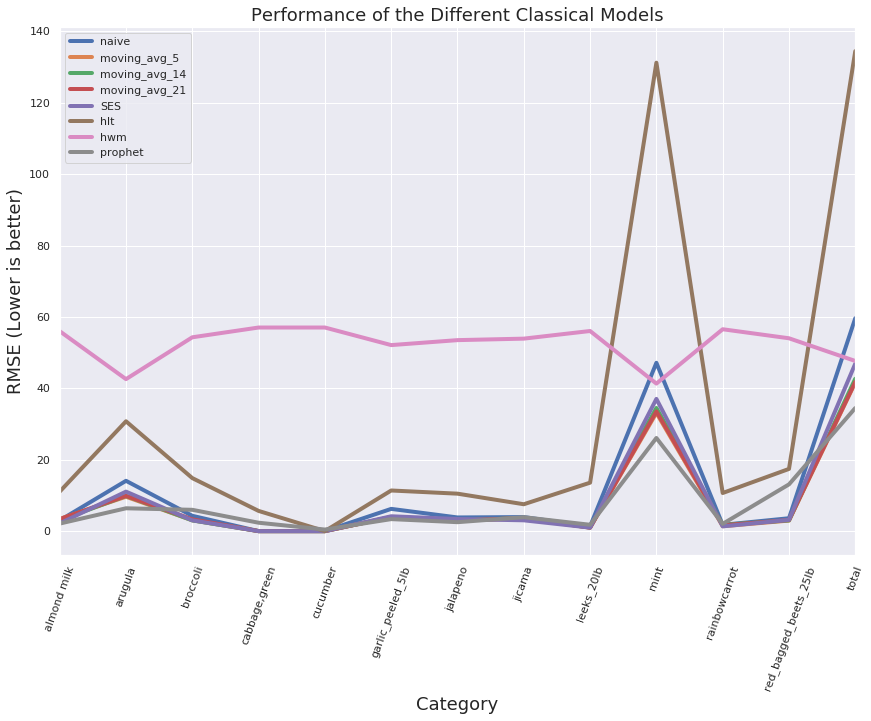

In [0]:
#RMSE
plot_models(results_r, "Performance of the Different Classical Models", "RMSE (Lower is better)")

#### *Remember the higher the higher the Mean Absolute Error, the worse off the model did. We can definitely take away both the holt linear trend and the holt winter method because those are visibally performing worse than the other models. This will also help us visually see which of the bottom models are performing the best.*

(0, 22)

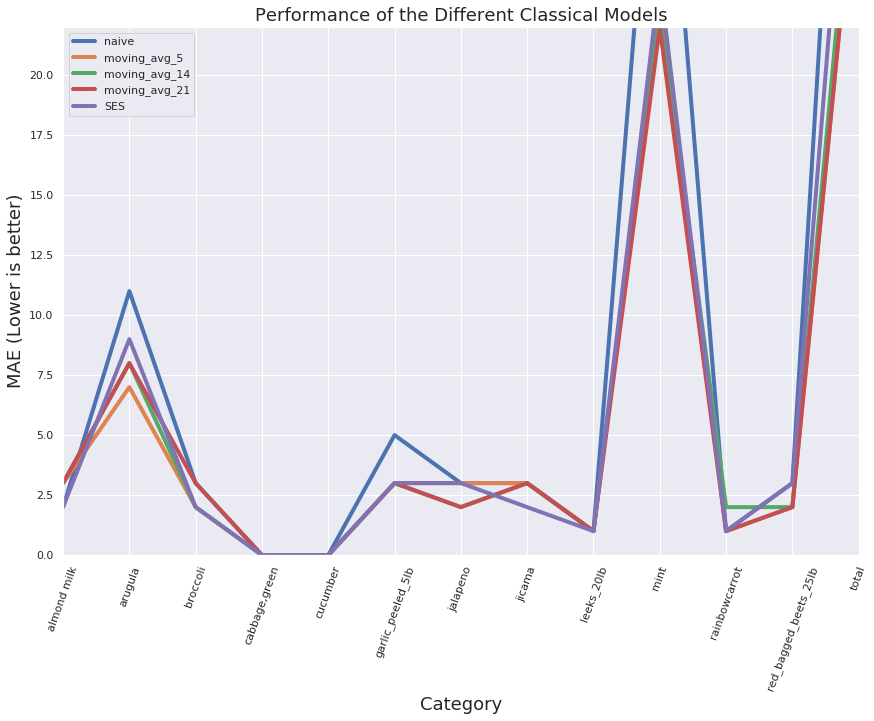

In [0]:
plot_models(results_m[['naive', 'moving_avg_5','moving_avg_14', 'moving_avg_21', 'SES']], "Performance of the Different Classical Models", "MAE (Lower is better)")
plt.ylim (0, 22)

### 7.1.2.3 Overall Insights

* THIS IS EXCELLENT! Some of the categories had significant improved performance from the naive model (between 33-42% increase of performance). This is a welcome change from the first notebook with data that was close to random walk process', and was having a hard time beating the naive forecast.

* Best model is the simple moving average, and setting the moving average to 14 or 21 days in the past (this makes sense since we saw weekly seasonality in the ACL plots). 

* Also, it looks like our greens, dairy_juice, and veg categories are all performing the worst. This is definitely something we should look a look at in the future, and see why these categories are being difficult to model. 


# Next Steps

1. Run this entire notebook on the ten most commonly sold items, and see how they perform and which models do the best
> I ran this experiment and the results were exactly the same with the simple moving average going back three weeks performing the best for all ten items overall. So good, even on an individual product level the models behaving the same as with the broad categories.
2. Proceed to the more complicated models and see how they compare to this model (Next up: Prophet!)

# 8. Prophet Model

*Now that we've established a few baseline and classical models, let's compare that against the performance of the prophet model.*

Some background on Prophet:

Where Prophet shines
Not all forecasting problems can be solved by the same procedure. Prophet is optimized for the business forecast tasks we have encountered at Facebook, which typically have any of the following characteristics:

* hourly, daily, or weekly observations with at least a few months (preferably a year) of history
* strong multiple “human-scale” seasonalities: day of week and time of year
* important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
* a reasonable number of missing observations or large outliers
* historical trend changes, for instance due to product launches or logging changes
* trends that are non-linear growth curves, where a trend hits a natural limit or saturates

How Prophet works:

At its core, the Prophet procedure is an additive regression model with four main components:

* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.


In [0]:
%pip install pystan
%pip install fbprophet
from fbprophet import Prophet


In [0]:
#resetting the data frame dates for the prophet model
dfqty.reset_index(inplace= True)
train.reset_index(inplace= True)

In [0]:
final = pd.DataFrame()
final['index']= train['index']#transferring over the date column
m_results= []
r_results = []

for num in range (1, len(train.columns)):
    col = dfqty.columns[num] #iterating through the columns minus the index column
    
    #renaming columns to suit the prophet needs
    new_df= train[['index', col]] 
    new_df.columns = ['ds', 'y']
    
    #fitting and forecasting
    m = Prophet()
    m.fit(new_df)
    future = m.make_future_dataframe(periods=53) #forecast the next 53 days (matching up with our train set)
    forecast = m.predict(future)   
    
    #adding columns to the final df
    final['yhat']= forecast['yhat']
    final['y'] = dfqty[col]
    
    #calculating MAE & RMSE
    m_results.append(round(mean_absolute_error(final['y'], final['yhat'])))
    r_results.append(sqrt(mean_squared_error(final['y'], final['yhat'])))
    
    #renaming columns to be specific to the category
    final = final.rename(columns={'yhat': 'yhat_'+ str(col), 'y':'y_'+ str(col)})
                                  
results_m['prophet']= m_results
results_r['prophet']= r_results
                                
    
print(final.head())
print (results_m.head())
  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

       index  yhat_almond milk  ...  yhat_total  y_total
0 2018-08-24          0.375231  ...  109.179301     94.0
1 2018-08-25          0.079829  ...   49.186191     51.0
2 2018-08-26         -0.704314  ...    4.146299      0.0
3 2018-08-27          1.510057  ...   99.249962    101.0
4 2018-08-28          2.896101  ...   83.699368     97.0

[5 rows x 27 columns]
               naive  moving_avg_5  moving_avg_14  ...   hlt   hwm  prophet
almond milk      2.0           3.0            3.0  ...  10.0  54.0      1.0
arugula         11.0           7.0            8.0  ...  26.0  39.0      4.0
broccoli         3.0           2.0            2.0  ...  12.0  52.0      4.0
cabbage,green    0.0           0.0            0.0  ...   5.0  55.0      1.0
cucumber         0.0           0.0            0.0  ...   0.0  55.0      0.0

[5 rows x 8 columns]


Text(0, 0.5, 'MAE (Lower is better)')

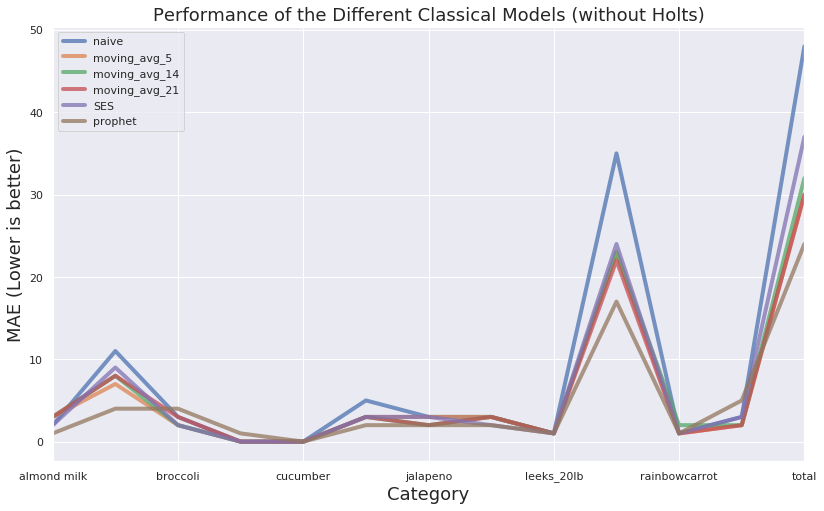

In [0]:
results_m[['naive', 'moving_avg_5','moving_avg_14', 'moving_avg_21', 'SES', 'prophet']].plot(figsize=(12,8), linewidth= 4, alpha= .75)
plt.title("Performance of the Different Classical Models (without Holts)", fontsize= 18)
plt.xlabel("Category", fontsize= 18)
plt.ylabel("MAE (Lower is better)", fontsize= 18)
#plt.ylim (0, 220)

Text(0, 0.5, 'RMSE (Lower is better)')

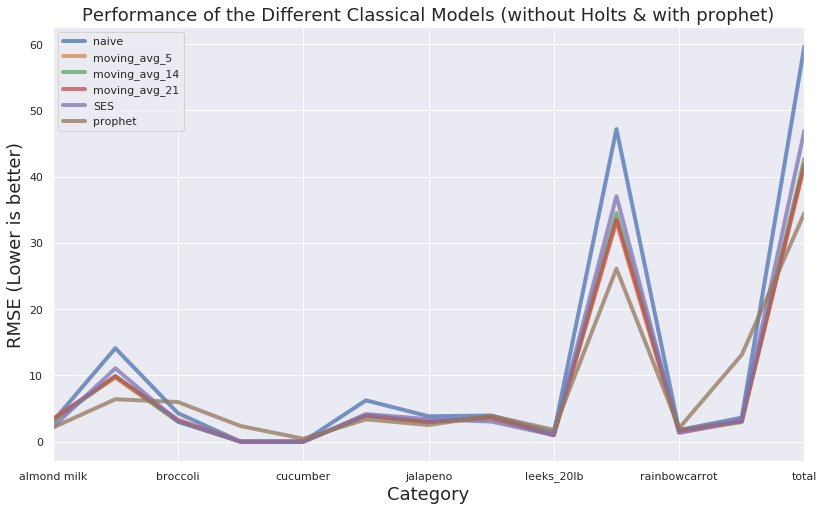

In [0]:
results_r[['naive', 'moving_avg_5','moving_avg_14', 'moving_avg_21', 'SES', 'prophet']].plot(figsize=(12,8), linewidth= 4, alpha= .75)
plt.title("Performance of the Different Classical Models (without Holts & with prophet)", fontsize= 18)
plt.xlabel("Category", fontsize= 18)
plt.ylabel("RMSE (Lower is better)", fontsize= 18)
#plt.ylim (0, 220)

In [0]:
m1 = Prophet(interval_width=0.95) #instantiating the prophet model, and customizing the prophet model for a 95% certainaty level
m = Prophet(interval_width=0.95)


In [0]:
m1.fit(fruit_t)
m.fit(fruit)

NameError: ignored

In [0]:
#creating a dataframe for the future
future_dates = m1.make_future_dataframe(periods=53)
fd = m.make_future_dataframe(periods=7)
future_dates.tail()



In [0]:
forecast = m1.predict(future_dates)
forecast2 = m.predict(fd)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


In [0]:
fig1 = m1.plot(forecast)
fig2 = m.plot(forecast2)#who fruit dataset


In [0]:
fig3 = m1.plot_components(forecast)
fig4 = m.plot_components(forecast2)

In [0]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='311 days', horizon = '53 days')
df_cv.head()

In [0]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

In [0]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')


In [0]:
#CREATING A CUSTOM FUTURE DATAFRAME

from datetime import datetime
from dateutil.relativedelta import relativedelta
future = [datetime(2016, 1, 1) + relativedelta(months=i, day=31) for i in range(24)]
future = pd.DataFrame(data=future, columns=[‘ds’])
prediction = model.predict(future)